**Regularisation**

In this example you are given a dataset (MNIST) with a limited number of training examples (only 1000 compared to the usual 60,000). 

Your goal is to implement regularisation methods to achive the **lowest possible test loss using this dataset**. 

You should consider methods given in the lectures including:

*   Data augmentation
*   Early stopping
*   L1/L2 penalty norms
*   Dropout

You are free to change the network architecture and model complexity, but the main purpose of the workshop is to investigate regularisation (next week you will look at CNN architectures in detail). 

You are also free to change the choice of optimiser, and other hyper-parameters such as the batch size.  


In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.python.keras import regularizers

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np
import random

In [3]:
tf.random.set_seed(1)

In [4]:
print(tf.__version__)

2.4.1


First load the MNIST dataset and add a channels dimension (channels last convention)

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

Let's use a much smaller training dataset of 1000 examples so overfitting is more problematic

In [6]:
n_train = 1000
x_train = x_train[0:n_train, :]
y_train = y_train[0:n_train]

print(x_train.shape)
print(x_test.shape)

(1000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [57]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 35
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

Let's visualise several training examples - to do this we use the keras ImageDataGenerator. We rescale images by 1/255 to normalise them in the range (0, 1)

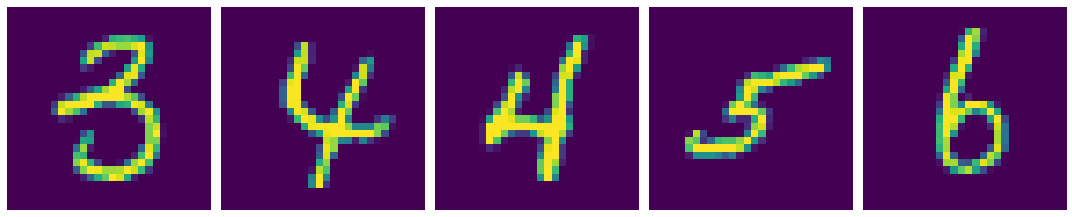

In [8]:
image_generator = ImageDataGenerator(rescale=1./255) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
sample_images, sample_labels = next(data_gen)
plotImages(sample_images[:5])

One regularisation method to deal with over-fitting is data augmentation. The image generator can apply various transformations to data - here we apply a random rotation of upto 20 degrees and visualise the same training example with different augmentations

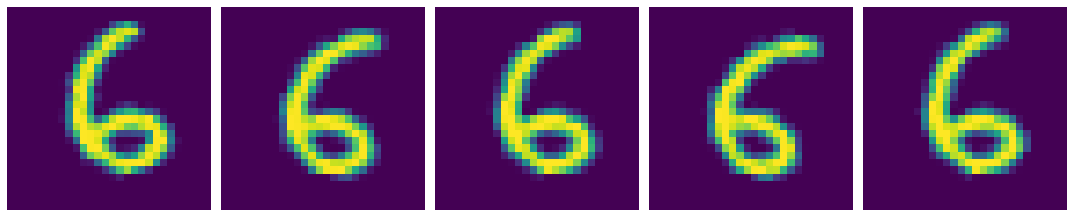

In [9]:
image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
augmented_images = [data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Define a basic CNN with 32 convolutional filters using a 3x3 kernel, followed by a dense fully connected layer of 128 units and an output layer of 10 units with softmax activation 

In [56]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    l = 0.0001
    self.conv1 = Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(l))
    self.conv2 = Conv2D(32, 3, activation='relu')
    self.conv3 = Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(l))
    self.drop1 = Dropout(0.2)
    self.flatten = Flatten()
    self.batch1 = BatchNormalization()
    self.d1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l))
    self.d2 = Dense(50, activation='relu')
    self.batch2 = BatchNormalization()
    self.d3 = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(l))

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.drop1(x)
    x = self.flatten(x)
    x = self.batch1(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.batch2(x)
    return self.d3(x)

In [51]:
x_train_aug = x_train
y_train_aug = y_train
for i in range(49):
    x_train_aug = np.concatenate((x_train_aug, x_train), axis = 0)
    y_train_aug = np.concatenate((y_train_aug, y_train), axis = 0)

Main training routine - uses the more detailed Gradient Tape API to iterate over the dataset and update the weights

In [58]:
def trainer(cls, train_image_generator, test_image_generator, 
            verbose=False, batch_size=32, max_epochs=5):
  
  model = cls()

  train_data_gen = train_image_generator.flow(x_train_aug, y_train_aug, 
                                              batch_size=batch_size) 

  test_data_gen = test_image_generator.flow(x_test, y_test, 
                                              batch_size=batch_size) 

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  optimizer = tf.keras.optimizers.Adam()

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')

  @tf.function
  def train_step(images, labels):
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

  @tf.function
  def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

  for epoch in range(max_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    batches = 0
    for images, labels in train_data_gen:
      #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
      train_step(images, labels)
      batches += 1
      if batches >= len(x_train) / batch_size:
        break

    batches = 0
    for images, labels in test_data_gen:
      test_step(images, labels)
      batches += 1
      if batches >= len(x_test) / batch_size:
        break

    if verbose:
      template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
      print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
    
  return test_loss.result().numpy()

Baseline run with no regularisation

In [ ]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.35,
        height_shift_range=0.35,
        zoom_range=0.3,
        preprocessing_function=add_noise)
 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=300, batch_size = 64)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 2.542130947113037, Accuracy: 14.84375, Test Loss: 2.3133046627044678, Test Accuracy: 13.429999351501465
Epoch 2, Loss: 2.279090642929077, Accuracy: 19.04296875, Test Loss: 2.2676265239715576, Test Accuracy: 12.819999694824219
Epoch 3, Loss: 2.1403589248657227, Accuracy: 24.51171875, Test Loss: 2.222956657409668, Test Accuracy: 10.65999984741211
Epoch 4, Loss: 2.0712990760803223, Accuracy: 27.9296875, Test Loss: 2.15893816947937, Test Accuracy: 16.94999885559082
Epoch 5, Loss: 1.9543068408966064, Accuracy: 32.8125, Test Loss: 2.143716335296631, Test Accuracy: 20.96000099182129
Epoch 6, Loss: 1.8476574420928955, Accuracy: 34.765625, Test Loss: 2.114906072616577, Test Accuracy: 21.389999389648438
Epoch 7, Loss: 1.7578355073928833, Accuracy: 41.50390625, Test Loss: 2.1159555912017822, Test Accuracy: 35.26000213623047
Epoch 8, Loss: 1.673598051071167, Accuracy: 41.89453125, Test Loss: 2.0595388412475586, Test Accuracy: 27.329999923706055
Epoch 9, Loss: 1.6042768955230713, Acc